In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm

# Periodic Signals & The Lomb-Scargle Periodogram
By AA Miller (2019 Jun ~10)  
Updated by G Hosseinzadeh (2025 May 27)

This notebook discusses the detection of periodic signals in noisy, irregular data (the standard for ground-based astronomical surveys). The discussion below is strongly influenced by "Understanding the Lomb-Scarge Periodogram" ([VanderPlas 2017](http://adsabs.harvard.edu/abs/2017arXiv170309824V)). Beyond that, the original papers by [Lomb (1976)](http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L) and [Scargle (1982)](http://adsabs.harvard.edu/abs/1982ApJ...263..835S) are also worth a read. Though there are many, many papers on the use of the Lomb-Scargle periodogram, [Graham et al. (2013)](http://adsabs.harvard.edu/abs/2013MNRAS.434.3423G) conducted a systematic analysis of many of the most popular tools used to search for periodic signals on *actual astronomical data* and found that none of the solutions work really well across all use cases!

We'll be using a sinusoidal model throughout this exercise, so write a function that implements the following equation:

$$ y = A\,\sin\left(\frac{2{\pi}x}{P} - \phi\right) + \sigma_y$$

where $A, P, \phi$ are free parameters. It should have the option to Gaussian noise, $\sigma_y$, for each output $y_i$.

Test that it works by generating a noise-free signal with $A = 2$ and $P = \pi$ over a regular grid between 0 and 10. Plot the results.

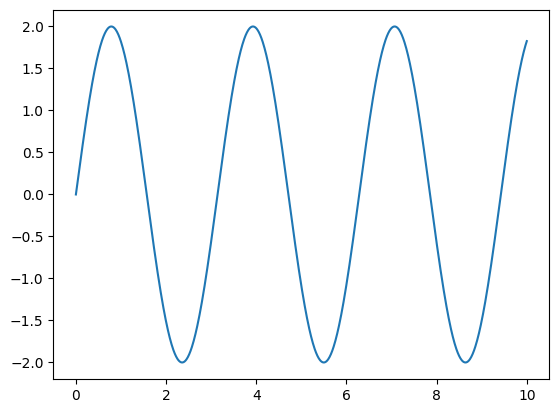

In [2]:
rng = np.random.default_rng()
#BEST FIT FLAT FUNC IS WIEGHTED MEAN OF ALL POINTS
def sinusoid(x, period=1, amplitude=1, phase=0, noise=0):

    return  (amplitude*np.sin(((2* np.pi * x)/(period))-(phase))) + rng.normal(0,noise,len(x))

x =  np.linspace(0,10,1000)
y = sinusoid(x,amplitude=2 , period=np.pi)
plt.plot(x,y)

## Problem 1) The Lomb-Scargle Periodogram

**Problem 1a**

Write a function, `chi2`, to calculate the $\chi^2$ given $f$, $A_f$, and $\phi$, for observations $y_n$ with uncertainties $\sigma_{y,n}$ taken at times $t_n$.

*Hint* - it may be helpful to access $A_f$, and $\phi$ from a single variable `theta`, where `a = theta[0]` and `phi = theta[1]`

In [3]:
#def chi2(f,theta,y_n,sigma,t_n):
   # A=theta[0]
 #   phi= theta[1]
 #   chi_2=0
  #  for i in len(y_n):
  #      chi_2= chi_2 + (((y_n[i])-(A* np.sin(2*np.pi*f(t_n[i] - phi))))/(sigma[i]))
  #  return chi_2
#theta=np.empty(2)

#kept getting odd errors so im reformatting this

def chi2(y_n, A, f, t_n, phi, noise_SD):
    model = A * np.sin(2 * np.pi * f * (t_n - phi))
    residuals = (y_n - model) / noise_SD
    chi2_val = np.sum(residuals**2)
    return chi2_val


**Problem 1b**

Write a function to minimize the $\chi^2$ given everything but $A_f$ and $\phi_f$.

*Hint* - you may find [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) within the `scipy` package useful.

In [4]:
from scipy.optimize import minimize

#def min_chi2(f,y_n,sigma,t_n):
 #   res =minimize(chi2,theta,args=(f,y_n,sigma,t_n))
 #   return res.fun
#If theres a way to make it work in this format idk , it was easier to have a nested func
#

def min_chi2(y_n, f, t_n, noise_SD):
    def chi2_wrapper(theta):
        A, phi = theta
        return chi2(y_n, A, f, t_n, phi, noise_SD)
    
 
    result = minimize(chi2_wrapper, [0.0,0.0], method='BFGS')
    return result.fun, result.x

**Problem 1c**

Write a function, `ls_periodogram`, to calculate the LS periodogram for observations $y$, $\sigma_y$, $t$ over a frequency grid `f_grid`.

In [5]:
#def ls_periodogram(f_grid,y_n,sigma,t_n):  # complete
#
   
#    psd = np.empty(f_grid.shape)
#    #chi2_0 = np.sum(np.power(y_n,2)*np.power(sigma,-2))/np.sum(np.power(sigma,-2))
#    chi2_0 = np.sum(( y_n - y_n.mean())/(sigma)**2)
#    for f_num, f in enumerate(f_grid):
#        psd[f_num] = (chi2_0- min_chi2(f,y_n,sigma,t_n))/2
#    return psd

def ls_periodogram(y, t, noise_SD, f_grid):
    psd = np.zeros(len(f_grid))
    
    # Calculate chi2_0 (null hypothesis - constant model)
    y_mean = np.mean(y)
    chi2_0 = np.sum(((y - y_mean) / noise_SD)**2)
    
    for f_num, f in enumerate(f_grid):
        chi2_min, _ = min_chi2(y, f, t, noise_SD)
        # Power spectral density calculation
        psd[f_num] = (chi2_0 - chi2_min) / 2
        
    return psd

**Problem 1d**

Generate a periodic signal with 100 observations taken over a time period of 10 days. Use an input period of 5.25, amplitude of 7.4, and variance of the noise = 0.8. To make this more realistic, randomly generate uncertainties from a half-Gaussian with a standard deviation of 0.8. Then compute and plot the periodogram for the simulated data. Do you recover the simulated period?

*Hint* - set the minimum frequency in the grid to $1/T$ where $T$ is the duration of the observations. Set the maximum frequnecy to 10, and use an equally spaced grid with 50 points. 

<ErrorbarContainer object of 3 artists>

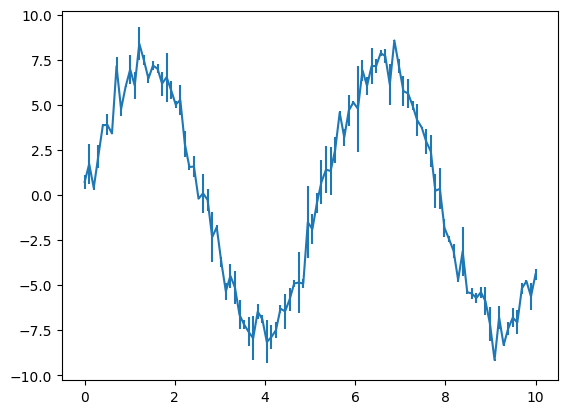

In [6]:
x =  np.linspace(0,10,100)
y =  sinusoid(x, period=5.25, amplitude=7.4, phase=0, noise=0.8)
y_unc =  np.abs(np.random.normal(loc=0, scale=0.8, size=100))

plt.errorbar(  x,y, yerr=y_unc)

The best fit period is: 3.3108


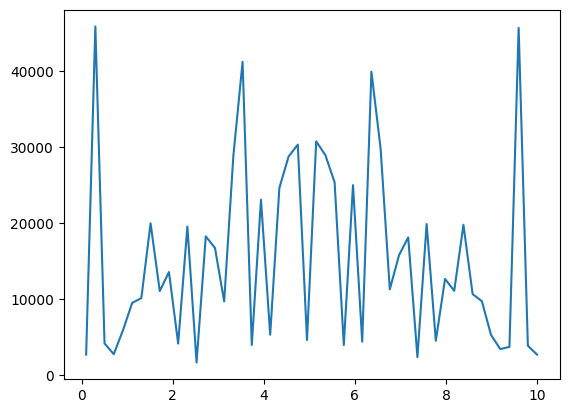

In [11]:
# calculate the periodogram
f_min =   1/10
f_grid =  np.linspace(f_min,10,50)
psd_ls =  ls_periodogram(y,x,y_unc,f_grid)

plt.plot(f_grid,psd_ls)
# complete
# complete
# complete
# complete

print("The best fit period is: {:.4f}".format(1. / f_grid[np.argmax(psd_ls)]))

**Problem 1e**

For the same data, include 1000 points in `f_grid` and calculate and plot the periodogram. 

Now do you recover the correct period?

The best fit period is: 0.1031


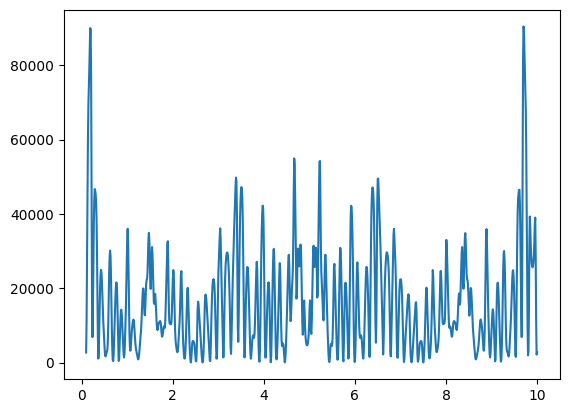

In [12]:
# calculate the periodogram
f_min =   1/10
f_grid =  np.linspace(f_min,10,1000)
psd_ls =  ls_periodogram(y,x,y_unc,f_grid)

plt.plot(f_grid,psd_ls)
# complete
# complete
# complete
# complete

print("The best fit period is: {:.4f}".format(1. / f_grid[np.argmax(psd_ls)]))

**Problem 1f**

Plot the phase-folded data at the newly found "best" fit period.

<ErrorbarContainer object of 3 artists>

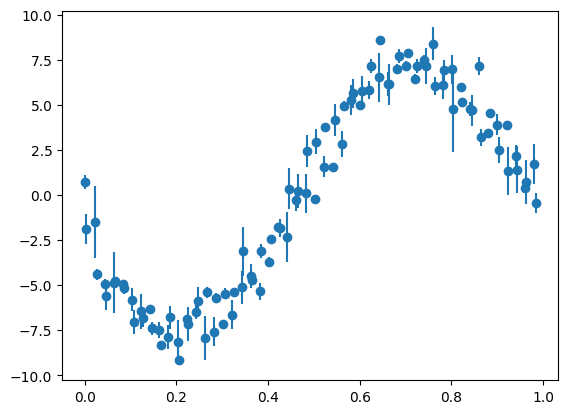

In [15]:
period = 1. / f_grid[np.argmax(psd_ls)]  # best period
phases = (x % period) / period #credit to boyce astro for this formula no idea if its right    
plt.errorbar(phases, y, yerr=y_unc, fmt='o')
# complete
# complete
# complete

**Problem 1g**

`ls_periodogram` functions well, but the way we implemented it is slow. [`LombScargle`](http://docs.astropy.org/en/stable/timeseries/lombscargle.html) in `astropy.timeseries` is fast. Run it below to compare the results to `ls_periodogram`. There are many choices regarding the calculation of the periodogram, so [read the docs](http://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html#astropy.timeseries.LombScargle).

best Period is: 0.10309278350515465


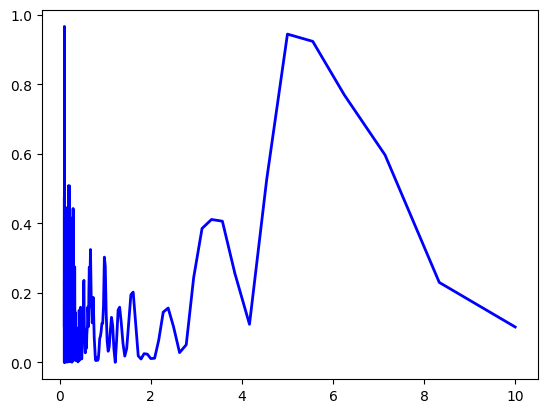

In [25]:
from astropy.timeseries import LombScargle
ls = LombScargle(x, y, y_unc, fit_mean=True)
frequency, power = ls.autopower(minimum_frequency=f_min,maximum_frequency=10,samples_per_peak=5)
plt.plot(1.0/frequency, power, 'b-', linewidth=2)  # Blue line like manual

best_period = 1.0 / frequency[np.argmax(power)]
print("best Period is:",best_period)
# complete
# complete
# complete

## Problem 2: Floating Mean Periodogram

A basic assumption that we preivously made is that the data are "centered" - in other words, our model explicitly assumes that the signal oscillates about a mean of 0.

For astronomical applications, this assumption can be harmful. Instead, it is useful to fit for the mean of the signal in addition to the periodic component (as is the default in `LombScargle`):

$$y(t;f) = y_0(f) + A_f \sin[2\pi f(t - \phi_f)].$$

To illustrate why this is important for astronomy, assume that any signal fainter than $-2$ in our simulated data cannot be detected. 

**Problem 2a**

Remove the observations from `x` and `y` where $y \le -2$ and calculate the periodogram both with and without fitting the mean (`fit_mean = False` in the call to `LombScargle`). Plot the periodograms. Do both methods recover the correct period? 

0.10500013291156066 with mean period
0.10500013291156066 without mean period


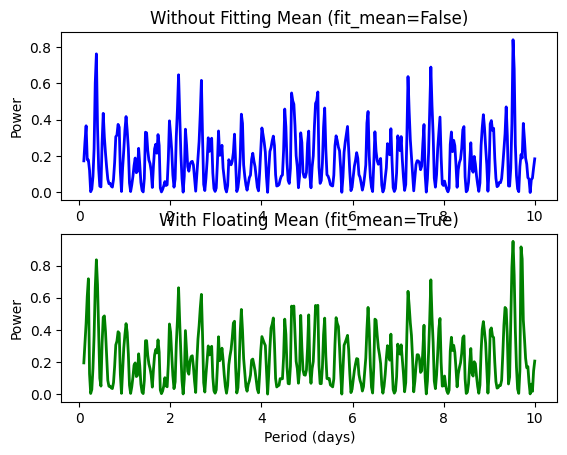

In [54]:
bright = y > -2
x_bright = x[bright]
y_bright = y[bright]
y_unc_bright = y_unc[bright]
freq_no_mean, power_no_mean = LombScargle(x_bright, y_bright, y_unc_bright, fit_mean=False).autopower(minimum_frequency=f_min,maximum_frequency=10,samples_per_peak=5)
freq_fit_mean, power_fit_mean = LombScargle(x_bright, y_bright, y_unc_bright, fit_mean=True).autopower(minimum_frequency=f_min,maximum_frequency=10,samples_per_peak=5)
 # complete

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(freq_no_mean, power_no_mean, 'b-', linewidth=2)
ax1.set_ylabel('Power')
ax1.set_title('Without Fitting Mean (fit_mean=False)')

ax2.plot(freq_fit_mean, power_fit_mean, 'g-', linewidth=2)
ax2.set_xlabel('Period (days)')
ax2.set_ylabel('Power')
ax2.set_title('With Floating Mean (fit_mean=True)')

best_freq_no_mean = freq_no_mean[np.argmax(power_no_mean)]
best_freq_fit_mean = freq_fit_mean[np.argmax(power_fit_mean)]
print(1/best_freq_fit_mean,"with mean period")
print(1/best_freq_no_mean,"without mean period")


They both give the right perod!

**Problem 2b**

Plot the reconstructed signals with and without the floating mean and compare them to the data.

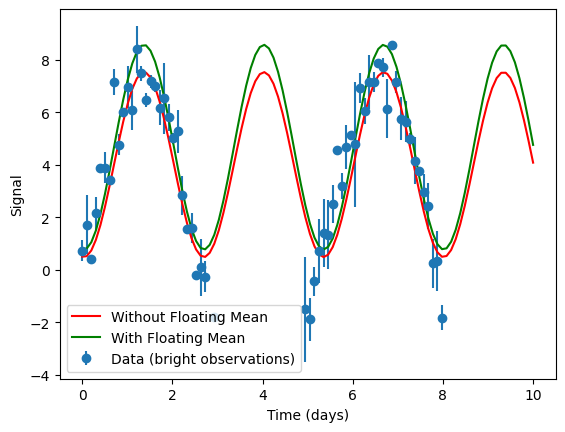

In [62]:
t_model = np.linspace(0, 10, 100)

fit_mean_model = LombScargle(x_bright, y_bright, y_unc_bright, fit_mean=True).model(t_model, best_freq_fit_mean)
no_mean_model =  LombScargle(x_bright, y_bright, y_unc_bright, fit_mean=False).model(t_model, best_freq_no_mean)

plt.errorbar(x_bright, y_bright, yerr=y_unc_bright, fmt='o', label='Data (bright observations)')
plt.plot(t_model, no_mean_model, 'r-',  label='Without Floating Mean')
plt.plot(t_model, fit_mean_model, 'g-',  label='With Floating Mean')
plt.xlabel('Time (days)')
plt.ylabel('Signal')
plt.legend()


## Problem 3: Window Functions

Let us simulate "realistic" observations for a 10 year telescope survey. We do this by assuming that a source is observed every 3 nights (the LSST cadence) within $\pm 4\,\mathrm{hr}$ of the same time, and that $\sim 30\%$ of the observations did not occur due to bad weather. We further assume that the source cannot be observed for 40% of the year because it is behind the sun.

**Problem 3a**

Simulate a periodic signal with 3 day cadence (and the observing conditions described above), a period = 220 days (typical for Miras), amplitude = 12.4, and variance of the noise = 1. Randomly generate uncertainties from a half-Gaussian with a standard deviation of 1. Plot the simulated light curve.

Text(0.5, 1.0, '10-Year Survey Simulation ')

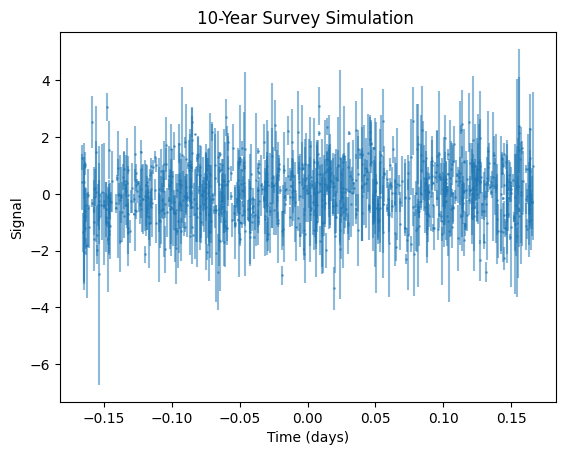

In [66]:
# set up simulated observations
t_obs =np.arange(0, 10*365, 3) # 3d cadence
t_obs = np.random.uniform(-4/24, 4/24, len(t_obs))
t_obs = t_obs[np.sin(2 * np.pi * t_obs / 365.25) > -0.2]
t_obs = t_obs[np.random.random(len(t_obs)) > 0.3]

y =  sinusoid(t_obs, period=220, amplitude=12.4, phase=0, noise=1.0)
y_unc =  np.abs(np.random.normal(0, 1, len(t_obs)))

plt.errorbar(t_obs, y, yerr=y_unc, fmt='o', alpha=0.5, markersize=1)  # complete
plt.xlabel('Time (days)')  # complete
plt.ylabel('Signal')  # complete
plt.title('10-Year Survey Simulation ')  # this is actually super cool!

**Problem 3b**

Calculate and plot the periodogram for the window function (i.e., set `y = 1` in `LombScargle`) of the observations. Do you notice any significant power? What are the periods for this power and what does this tell us?

*Hint* - you may need to zoom in on the plot to see all the relevant features.

Text(0.5, 1.0, 'Window Function Periodogram')

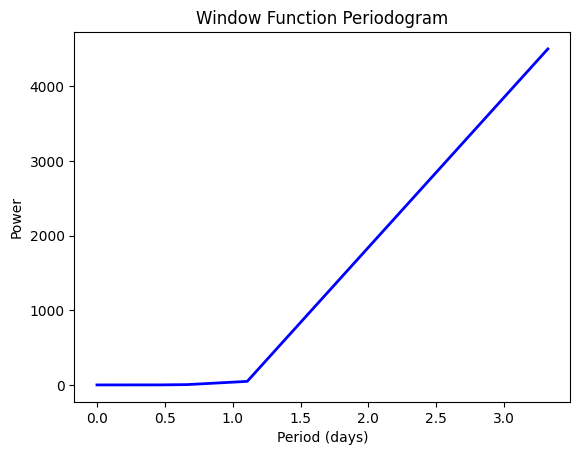

In [68]:
ls = LombScargle(t_obs, np.ones_like(t_obs)) 

freq_window, power_window = ls.autopower() 
plt.plot(1.0/freq_window, power_window, 'b-', linewidth=2) 
plt.xlabel('Period (days)')  # complete
plt.ylabel('Power')  # complete
plt.title('Window Function Periodogram')  
# complete
# complete
# complete
# complete

*Complete*

**Problem 3c**

Calculate the periodogram for the data and compare it to the periodogram for the window function. Do you notice any significant power? What are the periods for this power and what does this tell us?

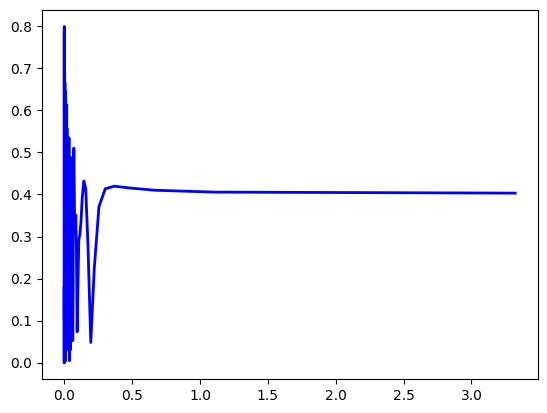

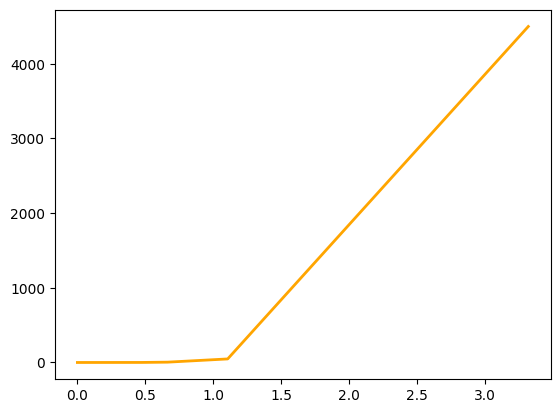

In [77]:
ls = LombScargle(t_obs, y, y_unc, fit_mean=True)

frequency, power = ls.autopower()  



# Data periodogram
plt.plot(1.0/frequency, power, 'b-', linewidth=2)  # complete
plt.show()

# Window function periodogram  
plt.plot(1.0/freq_window, power_window, 'orange', linewidth=2)  # complete
plt.show()

*Complete*